# Brain Segmentation

This tutorial will show how to use Fed-BioMed to perform image segmentation on 3D medical MRI images of brains, using the publicly available [IXI dataset](https://brain-development.org/ixi-dataset/). 
It uses a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) model for the segmentation, trained on data from 3 separate centers. 

Here we display a very complex case, using advanced Fed-BioMed functionalities such as:
- loading a MedicalImageDataset
- implementing a custom Node Selection Strategy
- setting a non-default Optimizer
- monitoring training loss with Tensorboard

This tutorial is based on [TorchIO's tutorial](https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=OoHXr1a4_9Ll).

## Data preparation

### Donwload  the data
Download the IXI dataset from the [Mendeley archive](https://data.mendeley.com/datasets/7kd5wj7v7p). 
Then separate your data in different folders for each center, in order to achieve the following structure:
```
_ Guys
 |_ train
 | |_ IXI002-Guys-0828
 | |_ ...
 | |_ participants.csv
 |_ holdout
    |_ IXI022-Guys-0701
     |_ ...
     |_ participants.csv
_ HH ....
```

## Automatic download and node creation
The script below will download and split the data into multiple centers (if not existing yet). 

We assume you are running this notebook from the folder `fedbiomed/notebooks/medical-image-segmentation`. If not, please replace the `../../` in the command below with the path to your `fedbiomed` folder.

After succesfully running the command, follow the instructions printed to add the datasets and run the nodes. The tag used for this experiment is `ixi-train`.

In [ ]:
%run -i download_and_split_ixi.py -f ../../

In [ ]:
%load_ext tensorboard

In [ ]:
! pip install matplotlib

## Define a new Strategy

Fed-BioMed's default strategy reads the number of samples per node through the `shape` parameter that is computed when the data is uploaded. 
For technical reasons, we need to change this to account for the fact that different modalities may have been used during the experiment. 

In [ ]:
from fedbiomed.researcher.strategies.default_strategy import DefaultStrategy
from fedbiomed.common.constants import ErrorNumbers
from fedbiomed.common.exceptions import FedbiomedStrategyError

class MedicalFolderStrategy(DefaultStrategy):
    def __init__(self, data, modalities = ['T1']):
        super().__init__(data)
        self._modalities = modalities
        
    def refine(self, training_replies, round_i):
        models_params = []
        weights = []

        # check that all nodes answered
        cl_answered = [val['node_id'] for val in training_replies.data()]

        answers_count = 0
        for cl in self.sample_nodes(round_i):
            if cl in cl_answered:
                answers_count += 1
            else:
                # this node did not answer
                logger.error(f'{ErrorNumbers.FB408.value} (node = {cl})')

        if len(self.sample_nodes(round_i)) != answers_count:
            if answers_count == 0:
                # none of the nodes answered
                msg = ErrorNumbers.FB407.value

            else:
                msg = ErrorNumbers.FB408.value

            logger.critical(msg)
            raise FedbiomedStrategyError(msg)

        # check that all nodes that answer could successfully train
        self._success_node_history[round_i] = []
        all_success = True
        for tr in training_replies:
            if tr['success'] is True:
                model_params = tr['params']
                models_params.append(model_params)
                self._success_node_history[round_i].append(tr['node_id'])
            else:
                # node did not succeed
                all_success = False
                logger.error(f'{ErrorNumbers.FB409.value} (node = {tr["node_id"]})')

        if not all_success:
            raise FedbiomedStrategyError(ErrorNumbers.FB402.value)

        # so far, everything is OK
        shapes = [sum(val[0]["shape"][modality][0] for modality in self._modalities) for (key, val) in self._fds.data().items()]
        totalrows = sum(shapes)
        weights = [x / totalrows for x in shapes]
        logger.info('Nodes that successfully reply in round ' +
                    str(round_i) + ' ' +
                    str(self._success_node_history[round_i]))
        return models_params, weights
        

## Create a Training Plan

We create a training plan that incorporates the UNet model. We choose to write the code for the UNet model instead of using the [unet](https://github.com/fepegar/unet) to avoid forcing the edge nodes (i.e. the hospitals) to install an additional dependency. 

Nevertheless, the code for UNet is taken from the library's implementation

*Pérez-García, Fernando. (2020). fepegar/unet: PyTorch implementation of 2D and 3D U-Net (v0.7.5). Zenodo.* https://doi.org/10.5281/zenodo.3697931

### Define the model
We define the model in the `__init__` and `forward` functions of the training plan. Note that this is quite a complex model, requiring multiple subclasses to be defined beforehand.

### Define the loss function
Loss function is computed based on the Dice Loss.

_Carole H Sudre, Wenqi Li, Tom Vercauteren, Sebastien Ourselin, and M Jorge Cardoso. Generalised dice overlap as a deep learning loss function for highly unbalanced segmentations. In Deep learning in medical image analysis and multimodal learning for clinical decision support, pages 240–248. Springer, 2017._

### Define data transformations
We define the image transformations for the input images and the labels. 

Additionally, we define a transformation for the demographics data. Note that this is a required step to ensure that the demographics csv data is transformed into a torch Tensor usable by the training routine.

### Define training step

Here we take as input one batch of (data, target), train the model and compute the loss function. 

Note that the `MedicalFolderDataset` class returns `data` as a tuple of `(images, demographics)`, where:
- `images` is a `dict` of `{modality: image`} (after image transformations)
- `demographics` is a `dict` of `{column_name: values}` where the column names are taken from the demographics csv file
while the `target` is a `dict` of `{modality: image`} (after target transformations). 

In our case, the modality used is `T1` for the input images, while the modality used for the target is `label`. We also ignore the values of the demographics data during training because the UNet model only takes images as input, but the code provided still shows the recommended way to handle such data. 


In [ ]:
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager, MedicalFolderDataset
import torch.nn as nn
from torch.optim import AdamW
from unet import UNet

class UNetTrainingPlan(TorchTrainingPlan):
    # Init of UNetTrainingPlan
    def __init__(self, model_args: dict = {}):
        super(UNetTrainingPlan, self).__init__(model_args)
        self.CHANNELS_DIMENSION = 1
        
        self.unet = UNet(
            in_channels = model_args.get('in_channels',1),
            out_classes = model_args.get('out_classes',2),
            dimensions = model_args.get('dimensions',2),
            num_encoding_blocks = model_args.get('num_encoding_blocks',5),
            out_channels_first_layer = model_args.get('out_channels_first_layer',64),
            normalization = model_args.get('normalization', None),
            pooling_type = model_args.get('pooling_type', 'max'),
            upsampling_type = model_args.get('upsampling_type','conv'),
            preactivation = model_args.get('preactivation',False),
            residual = model_args.get('residual',False),
            padding = model_args.get('padding',0),
            padding_mode = model_args.get('padding_mode','zeros'),
            activation = model_args.get('activation','ReLU'),
            initial_dilation = model_args.get('initial_dilation',None),
            dropout = model_args.get('dropout',0),
            monte_carlo_dropout = model_args.get('monte_carlo_dropout',0)
        )
        
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        deps = ["from monai.transforms import (Compose, NormalizeIntensity, AddChannel, Resize, AsDiscrete)",
               "import torch.nn as nn",
               'import torch.nn.functional as F',
               "from fedbiomed.common.data import MedicalFolderDataset",
               'import numpy as np',
               'from torch.optim import AdamW',
               'from unet import UNet']
        self.add_dependency(deps)
        
        self.optimizer = AdamW(self.parameters())

    def forward(self, x):
        x = self.unet.forward(x)
        x = F.softmax(x, dim=self.CHANNELS_DIMENSION)
        return x
    
    @staticmethod
    def get_dice_loss(output, target, epsilon=1e-9):
        CHANNELS_DIMENSION = 1
        SPATIAL_DIMENSIONS = 2, 3, 4
        p0 = output
        g0 = target
        p1 = 1 - p0
        g1 = 1 - g0
        tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
        fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
        fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
        num = 2 * tp
        denom = 2 * tp + fp + fn + epsilon
        dice_score = num / denom
        return 1. - dice_score
    
    @staticmethod
    def demographics_transform(demographics):
        """Transforms dict of demographics into data type for ML.
        
        Must return either a torch Tensor or something Tensor-like
        that can be easily converted through the torch.as_tensor()
        function."""
        
        if isinstance(demographics, dict) and len(demographics) == 0:
            # when input is empty dict, we don't want to transform anything
            return demographics
        
        # simple example: keep only some keys
        keys_to_keep = ['HEIGHT', 'WEIGHT']
        out = np.array([float(val) for key, val in demographics.items() if key in keys_to_keep])
        
        # more complex: generate dummy variables for site name
        # not ideal as it requires knowing the site names in advance
        # could be better implemented with some preprocess
        site_names = ['Guys', 'IOP', 'HH']
        len_dummy_vars = len(site_names) + 1
        dummy_vars = np.zeros(shape=(len_dummy_vars,))
        site_name = demographics['SITE_NAME']
        if site_name in site_names:
            site_idx = site_names.index(site_name)
        else:
            site_idx = len_dummy_vars - 1
        dummy_vars[site_idx] = 1.
        
        return np.concatenate((out, dummy_vars))
        

    def training_data(self,  batch_size = 4):
    # The training_data creates the Dataloader to be used for training in the general class Torchnn of fedbiomed
        common_shape = (48, 60, 48)
        training_transform = Compose([AddChannel(), Resize(common_shape), NormalizeIntensity(),])
        target_transform = Compose([AddChannel(), Resize(common_shape), AsDiscrete(to_onehot=2)])
        
        dataset = MedicalFolderDataset(
            root=self.dataset_path,
            data_modalities='T1',
            target_modalities='label',
            transform=training_transform,
            target_transform=target_transform,
            demographics_transform=UNetTrainingPlan.demographics_transform)
        train_kwargs = {'batch_size': batch_size, 'shuffle': True}
        return DataManager(dataset, **train_kwargs)
    
    
    def training_step(self, data, target):
        #this function must return the loss to backward it 
        img = data[0]['T1']
        demographics = data[1]
        output = self.forward(img)
        loss = UNetTrainingPlan.get_dice_loss(output, target['label'])
        avg_loss = loss.mean()
        return avg_loss
    
    def testing_step(self, data, target):
        img = data[0]['T1']
        demographics = data[1]
        target = target['label']
        prediction = self.forward(img)
        loss = UNetTrainingPlan.get_dice_loss(prediction, target)
        avg_loss = loss.mean()  # average per batch
        return avg_loss


## Prepare the experiment

In [ ]:
model_args = {
    'in_channels': 1,
    'out_classes': 2,
    'dimensions': 3,
    'num_encoding_blocks': 3,
    'out_channels_first_layer': 8,
    'normalization': 'batch',
    'upsampling_type': 'linear',
    'padding': True,
    'activation': 'PReLU',
}

training_args = {
    'batch_size': 16, 
    'lr': 0.001, 
    'epochs': 2, 
    'dry_run': False,
    'log_interval': 2,
    'test_ratio' : 0.1,
    'test_on_global_updates': True,
    'test_on_local_updates': True,
}

In [ ]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['ixi-train']
num_rounds = 3

exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=UNetTrainingPlan,
                 training_args=training_args,
                 round_limit=num_rounds,
                 aggregator=FedAverage(),
                 tensorboard=True
                )
medical_folder_strategy = MedicalFolderStrategy(exp._fds, modalities=['T1'])
_ = exp.set_strategy(node_selection_strategy=medical_folder_strategy)

In [ ]:
from fedbiomed.researcher.environ import environ
tensorboard_dir = environ['TENSORBOARD_RESULTS_DIR']

In [ ]:
tensorboard --logdir "$tensorboard_dir"

On a Macbook Pro from 2015 with a 2,5 GHz Quad-Core Intel Core i7 processor and 16GB of DRAM, training for 3 rounds of 2 epochs each took about 30 minutes.
The final training curves look like this:

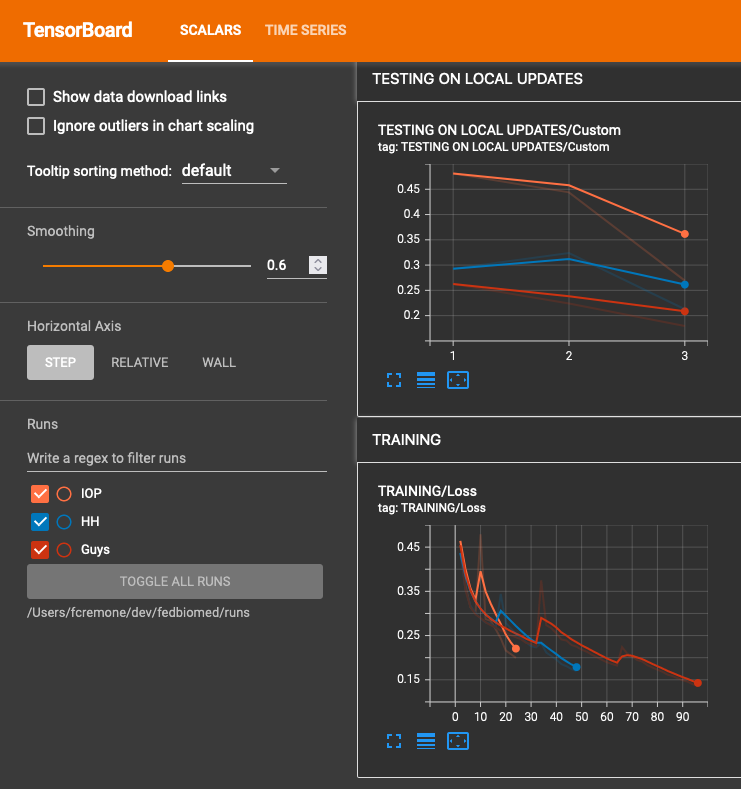

## Run the experiment

In [ ]:
exp.run()

## Validate on a local holdout set

To ensure consistency and simplify our life, we try to reuse the already-available code as much as possible. Note that this process assumes that the held-out data is stored locally on the machine. 

### Create an instance of the global model
First, we create an instance of the model using the parameters from the latest aggregation round.

In [ ]:
local_model = UNetTrainingPlan(model_args)

In [ ]:
for dependency_statement in local_model.dependencies:
    exec(dependency_statement)

In [ ]:
local_model.load_state_dict(exp.aggregated_params()[num_rounds-1]['params'])

### Define a validation data loader

We extract the validation data loader from the training plan as well. This requires some knowledge about the internals of the `MedicalFolderDataset` class. At the end of the process, calling the `split` function with a ratio of 0 will return a data loader that loads all of the data.

In [ ]:
from torch.utils.data import DataLoader
dataset_parameters = {
    'tabular_file': '/path/to/UniCancer-Centers/Guys/holdout/participants.csv',
    'index_col': 14
}
local_model.dataset_path = '/path/to/UniCancer-Centers/Guys/holdout/'
val_data_manager = local_model.training_data(batch_size=4)
val_data_manager._dataset.set_dataset_parameters(dataset_parameters)
val_data_loader = DataLoader(val_data_manager._dataset)

### Compute the loss on validation images

In [ ]:
losses = []
local_model.eval()

with torch.no_grad():
    for (images, demographics), targets in val_data_loader:
        image = images['T1']
        target = targets['label']
        prediction = local_model.forward(image)
        loss = UNetTrainingPlan.get_dice_loss(prediction, target)
        losses.append(loss)

### Visualize the outputs

As a bonus, we visualize the outputs of our model on the holdout dataset. 

In [ ]:
one_batch = next(iter(val_data_loader))

`one_batch` contains both input features and labels. Both are 3D images, which can be accessed in the following way (`k` represents the _height_ in the stack of images):

In [ ]:
k = 24
one_batch[1]['label'][..., k].shape

In [ ]:
k = 24
one_batch[0][0]['T1'][..., k].shape

In [ ]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
import torchvision
from IPython import display

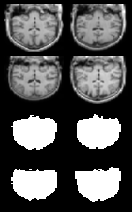

In [ ]:
k = 24
batch_mri = one_batch[0][0]['T1'][..., k]
batch_label = one_batch[1]['label'][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_whole_images.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=max(val_data_loader.batch_size//2,1),
    normalize=True,
    scale_each=True,
    padding=4,
)
display.Image(image_path, width=300)